# Project goal

This part of the poject is focused on the covid-19 Italy analysis.
The goal list is the following:
<ul>
<li>visualization and analysis of the main indicators about the severity of the disease (confirmed deaths, confirmed cases, intensive care people, hospitalized people);</li>
<li>identify if there is a correlation about how the disease is spread in a country and features like population density;</li>
<li>identify if it is possible to predict when the emergency status is going to an end in the most impacted countries and countermeasures put in place (in example the lockdown of a province);</li>
</ul>

# Datasets

The datasets used in this italian part of the project are the following:
https://github.com/pcm-dpc/COVID-19

This dataset was chosen for two reasons:
<ul>
<li>It's really complete and up to date. Everyday a new entry is added, for provinces and regions.</li>
<li>There are information about everything, like number of tampons, deaths and even hospitilized people.</li>
</ul>   
The downside is that every day is a different file, so in the project every file is selected to generate a new dataset with everything inside and completely automated, taking every entry until the day before.

The other dataset is the following:
https://worldpopulationreview.com/countries/italy-population/cities/

This dataset contains up to date information about italian city population.
There are some missing entries about provinces, so it was necessary to add them manually in the dataset.
It is also badly formatted, resulting in a bad pandas scheme.
The dataset used is a manually modified version of this one.

Another useful dataset would be the density of the population by city, but was not available, so it has been created manually, using wikipedia information.
Since there are 107 provinces in Italy, the region population density was taken, because it's probably more significative than doing that for every single city, and it can be done in a reasonable amount of time.

# Libraries

In [1]:
import numpy as np
import os
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
from datetime import date,timedelta
import copy
from statsmodels.tsa.arima_model import ARIMA

# Useful functions

Import utiliy functions.

In [11]:
yesterday = date.today() - timedelta(days=1)

date_list=pd.date_range(start="2020-02-24",end=yesterday) #time period from when the datasets starts until yesterday
str_date=[]
str_date_formatted=[]
#formatting the data to use it as a name of the columns of the new dataset and to use it for the github files
for i in range(len(date_list)):
    str_date.append(str(date_list[i]).replace("-", ""))
    str_date_formatted.append(str_date[i][:-9])

%run Utilities.ipynb

# Dataset rielaboration - Provinces

There are many csv files with shared information.
The following procedure is used to merge different datasets into a unique dataset.

Files are taken directly from the website of github. Everytime that new files are available, they are merged to the full dataset.

In [3]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[0]+'.csv'
time_line_dataset = pd.read_csv(url)
del time_line_dataset['totale_casi']

for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[i]+'.csv'    
    temp_data=pd.read_csv(url)
    time_line_dataset[str_date_formatted[i]]=temp_data['totale_casi']
 
#removing empty data
##NB: Naples has problems with NA. We decided to modify the field directly from the base dataset. So that even if we update 
##the dataset should work no problem
time_line_dataset=time_line_dataset[time_line_dataset.sigla_provincia.notnull()]

#removing useless/redundant columns
del time_line_dataset['data'] #we already have data columns added in the reworking
del time_line_dataset['stato'] #it's the italian database, we already know
del time_line_dataset['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['codice_provincia'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['lat'] #We don't need this value knowing the city
del time_line_dataset['long'] #We don't need this value knowing the city
del time_line_dataset['sigla_provincia'] #We don't need this value knowing the city
del time_line_dataset['note_it']
del time_line_dataset['note_en']

#saving reworked dataset. TURN THE OPTION ON IF IT IS NECESSARY TO SAVE IT TO EXTERNAL FILE.
#time_line_dataset.to_csv('rielab_dataset_merged.csv') 

# Dataset rielaboration - Provinces Graphs

Exploring the dataset to mine useful information.
Plot data to visualize ongoing desease in the various provinces.

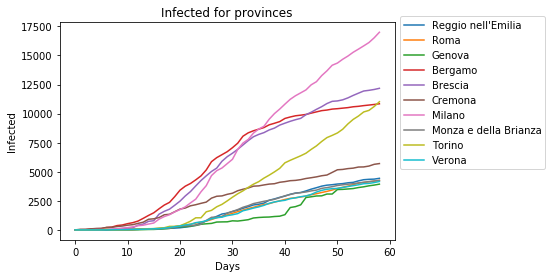

<Figure size 432x288 with 0 Axes>

In [6]:
x=len(time_line_dataset.columns[2:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])

Milano is the most hit province for number of infected.

Some new information could be required to have a better picture.
One of this information is the total population for each city taken in exam.

In [12]:
population=pd.read_csv('../Italy_analysis/dati aggiuntivi/it.csv',encoding = "ISO-8859-1")

difference =pd.Index(time_line_dataset['denominazione_provincia'].tolist()).symmetric_difference( population['index'])
population_time_line_dataset=time_line_dataset.merge(population, left_on='denominazione_provincia', right_on='index')
del population_time_line_dataset['location']
del population_time_line_dataset['google']
del population_time_line_dataset['index']

population_time_line_dataset.head()

,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200414,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,population
0,Abruzzo,Chieti,0,0,0,0,0,0,0,0,...,469,469,499,553,566,571,606,613,648,44444
1,Abruzzo,L'Aquila,0,0,0,0,0,0,0,0,...,228,229,232,233,233,237,237,238,238,33691
2,Abruzzo,Pescara,0,0,0,0,0,0,0,0,...,947,971,1005,1042,1071,1094,1143,1190,1215,116596
3,Abruzzo,Teramo,0,0,0,1,1,2,5,5,...,601,605,610,615,617,619,626,626,632,36099
4,Basilicata,Matera,0,0,0,0,0,0,0,0,...,155,155,169,170,172,174,174,177,181,54891


# Dataset rielaboration - Regions

Create different datasets for each condition (deaths, tampons, etc.) and then plot the data. In this way, it will be easy afterward to analyze them.

In [14]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[0]+'.csv'
time_line_dataset_regions = pd.read_csv(url)

#adding density information from our dataset
density=pd.read_csv('../Italy_analysis/dati aggiuntivi/density.csv')

#removing useless/redundant columns
del time_line_dataset_regions['data'] #we already have data columns added in the reworking
del time_line_dataset_regions['stato'] #it's the italian database, we already know
del time_line_dataset_regions['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset_regions['ricoverati_con_sintomi'] #this column will be its own dataset
del time_line_dataset_regions['lat'] #We don't need this value knowing the city
del time_line_dataset_regions['long'] #We don't need this value knowing the city
del time_line_dataset_regions['note_it']
del time_line_dataset_regions['note_en']
del time_line_dataset_regions['casi_testati']
del time_line_dataset_regions['terapia_intensiva'] #this column will be its own dataset
del time_line_dataset_regions['totale_ospedalizzati'] #this column will be its own dataset
del time_line_dataset_regions['isolamento_domiciliare']#this column will be its own dataset
del time_line_dataset_regions['totale_positivi'] #this column will be its own dataset
del time_line_dataset_regions['nuovi_positivi']#this column will be its own dataset
del time_line_dataset_regions['dimessi_guariti']#this column will be its own dataset
del time_line_dataset_regions['variazione_totale_positivi']#this column will be its own dataset
del time_line_dataset_regions['deceduti'] #this column will be its own dataset
del time_line_dataset_regions['totale_casi'] #this column will be its own dataset
del time_line_dataset_regions['tamponi'] #this column will be its own dataset

#building a dataset for condition
tl_hospitalized_with_symptoms=copy.deepcopy(time_line_dataset_regions)
tl_intensive_teraphy=copy.deepcopy(time_line_dataset_regions)
tl_total_hospitalized=copy.deepcopy(time_line_dataset_regions)
tl_isolation=copy.deepcopy(time_line_dataset_regions)
tl_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_new_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_recovered=copy.deepcopy(time_line_dataset_regions)
tl_deaths=copy.deepcopy(time_line_dataset_regions)
tl_total=copy.deepcopy(time_line_dataset_regions)
tl_tampons=copy.deepcopy(time_line_dataset_regions)
tl_variance=copy.deepcopy(time_line_dataset_regions)

#This one will contain the population density now on
time_line_dataset_regions=time_line_dataset_regions.merge(density, left_on='denominazione_regione', right_on='Region')
del time_line_dataset_regions['Region']

#uploading every day for each dataset
for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[i]+'.csv'
    
    temp_data=pd.read_csv(url)
    tl_hospitalized_with_symptoms[str_date_formatted[i]]=temp_data['ricoverati_con_sintomi']
    tl_intensive_teraphy[str_date_formatted[i]]=temp_data['terapia_intensiva']
    tl_total_hospitalized[str_date_formatted[i]]=temp_data['totale_ospedalizzati']
    tl_isolation[str_date_formatted[i]]=temp_data['isolamento_domiciliare']
    tl_actual_positives[str_date_formatted[i]]=temp_data['totale_positivi']
    tl_new_actual_positives[str_date_formatted[i]]=temp_data['nuovi_positivi']
    tl_recovered[str_date_formatted[i]]=temp_data['dimessi_guariti']
    tl_deaths[str_date_formatted[i]]=temp_data['deceduti']
    tl_total[str_date_formatted[i]]=temp_data['totale_casi']
    tl_tampons[str_date_formatted[i]]=temp_data['tamponi']
    tl_variance[str_date_formatted[i]]=temp_data['variazione_totale_positivi']


# Dataset rielaboration - Regions Graphs

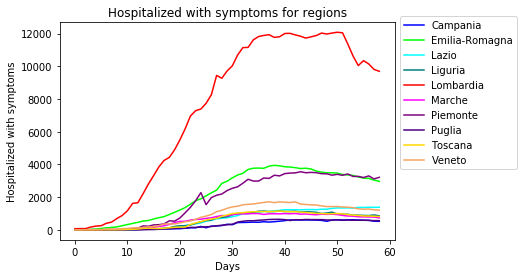

<Figure size 432x288 with 0 Axes>

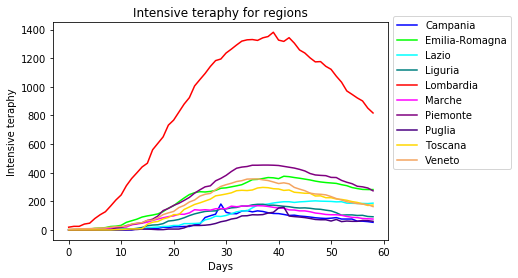

<Figure size 432x288 with 0 Axes>

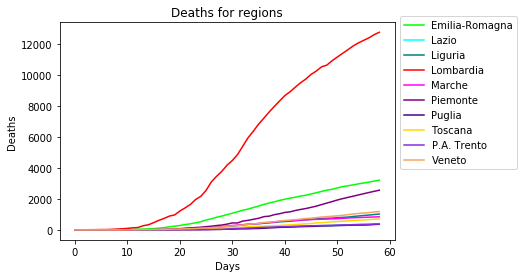

<Figure size 432x288 with 0 Axes>

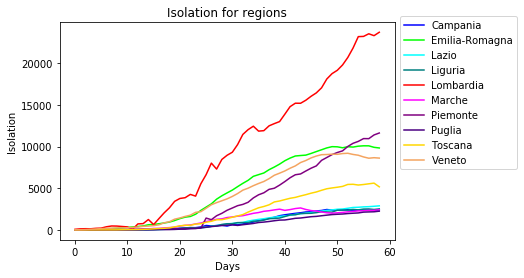

<Figure size 432x288 with 0 Axes>

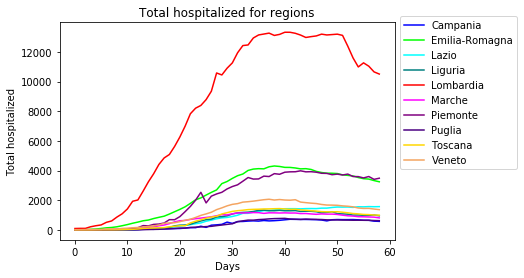

<Figure size 432x288 with 0 Axes>

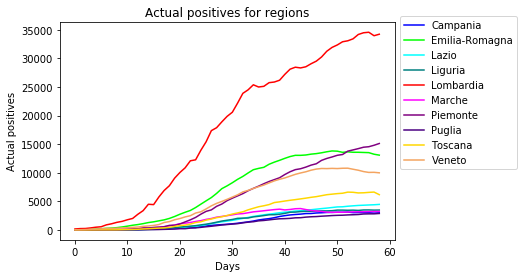

<Figure size 432x288 with 0 Axes>

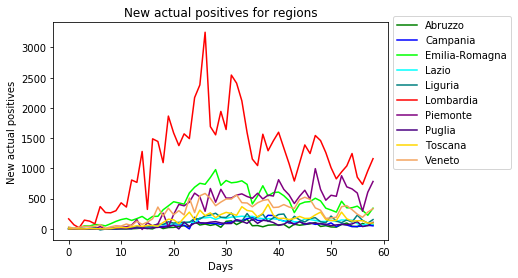

<Figure size 432x288 with 0 Axes>

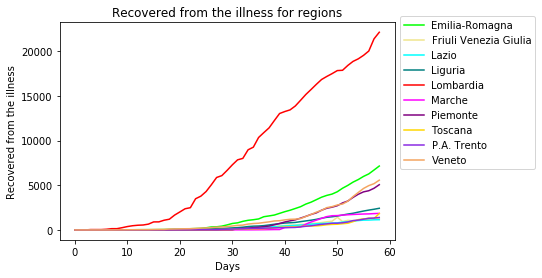

<Figure size 432x288 with 0 Axes>

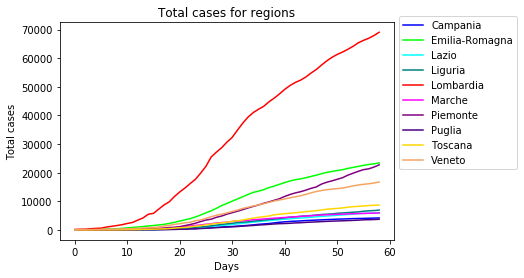

<Figure size 432x288 with 0 Axes>

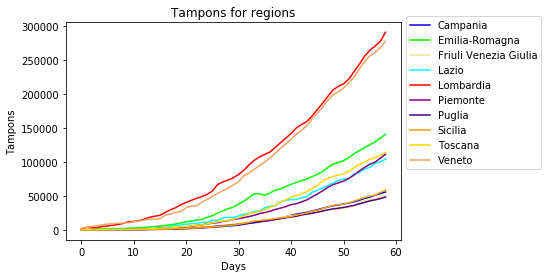

<Figure size 432x288 with 0 Axes>

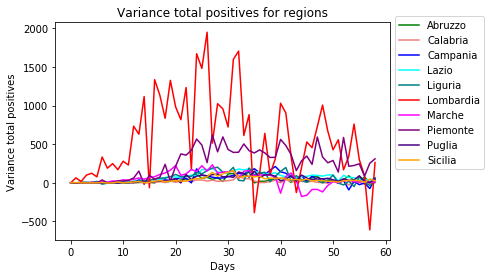

<Figure size 432x288 with 0 Axes>

In [15]:
x=len(tl_hospitalized_with_symptoms.columns[1:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(tl_hospitalized_with_symptoms,0),['Hospitalized with symptoms','regions'])
condition_plot(x,top_ten_list(tl_intensive_teraphy,0),['Intensive teraphy','regions'])
condition_plot(x,top_ten_list(tl_deaths,0),['Deaths','regions'])
condition_plot(x,top_ten_list(tl_isolation,0),['Isolation','regions'])
condition_plot(x,top_ten_list(tl_total_hospitalized,0),['Total hospitalized','regions'])
condition_plot(x,top_ten_list(tl_actual_positives,0),['Actual positives','regions'])
condition_plot(x,top_ten_list(tl_new_actual_positives,0),['New actual positives','regions'])
condition_plot(x,top_ten_list(tl_recovered,0),['Recovered from the illness','regions'])
condition_plot(x,top_ten_list(tl_total,0),['Total cases','regions'])
condition_plot(x,top_ten_list(tl_tampons,0),['Tampons','regions'])
condition_plot(x,top_ten_list(tl_variance,0),['Variance total positives','regions'])

Lombardia is the worst region in all the desease features.

# Data in depth

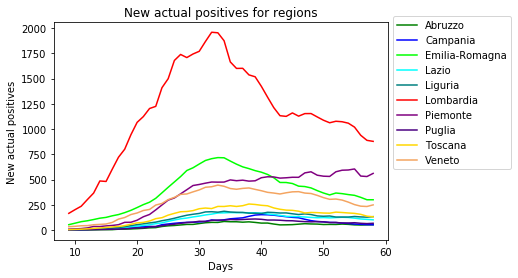

<Figure size 432x288 with 0 Axes>

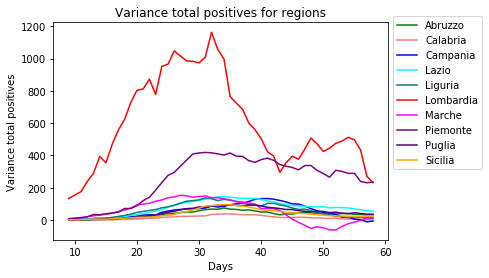

<Figure size 432x288 with 0 Axes>

In [16]:
x=len(tl_hospitalized_with_symptoms.columns[1:]) 
x=range(9,x) #Starting index is in regars of the window frame of the moving mean, in this case 10 (0 to 9)

moving_averages_NPositive=moving_mean_with_names(top_ten_list(tl_new_actual_positives,0),10)
moving_averages_variance=moving_mean_with_names(top_ten_list(tl_variance,0),10)
condition_plot(x,moving_averages_NPositive,['New actual positives','regions'])
condition_plot(x,moving_averages_variance,['Variance total positives','regions'])

@Luca: questo proprio non sono riuscito a capirne il senso.

With smoother lines we can have smoother conclusions about these two graphs.

# Data comparison


In this section, a comparison between graphs was carried out to gather information via data visualization.
Data modelling is best suited for this kind of job, but it is worth starting in this way.

@Luca: ma dove sono i grafici che vengono confrontati? Ne vedo solo 1.

   denominazione_regione  Density(ab./Km^2)
8              Lombardia             422.76
3               Campania             422.25
6                  Lazio             340.47
7                Liguria             286.30
17                Veneto             267.42
12                Puglia             205.33
4         Emilia-Romagna             198.62
14               Sicilia             192.36
11              Piemonte             171.60
15               Toscana             162.25


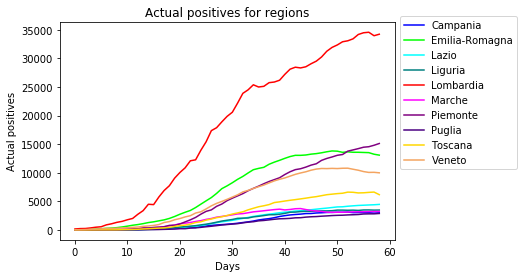

<Figure size 432x288 with 0 Axes>

In [18]:
print(time_line_dataset_regions.sort_values(by=['Density(ab./Km^2)'],ascending=False)[:10])
x=len(tl_hospitalized_with_symptoms.columns[1:]) 
x=range(0,x)
condition_plot(x,top_ten_list(tl_actual_positives,0),['Actual positives','regions'])

As a matter of fact, it is possible to see that every single region with the greater number of infected, is in the list of the most density population list.
It's not a perfect match, because even though Lombardia is in the first place of both rankings, other regions are not. In example, Campania occupy the second place of the population density ranking, but it's one of the lower displayed in the actual positive graph.
More than one factor could concern this aspect, such as the date of lockdown, or the population behavior, but it seems that the density population helped the diffusion of the virus as well.

# Provinces considering the number of inhabitants

Since the distribution of the population for each city could give misleading information, a sample of 30000 inhabitants to even the things up was used.
Most of the italian cities hover around that value, with big outliers like the big cities(Milano ecc..) that value should be reasonable.
In the next step a comparison with the previous graph was done.

@Luca: occorre dimostrare in qualche modo la scelta dei 30000 abitanti. Fai un grafico con la distribuzione del numero di abitanti per città, la media, o qualsiasi altra cosa che caratterizzi la scelta. Scrivimi poi in italiano cosa intendevi con questa frase:
'with big outliers like the big cities(Milano ecc..) that value should be reasonable'.

In [19]:
population_time_line_dataset['for30k']=(population_time_line_dataset[str(yesterday).replace("-", "")]/population_time_line_dataset['population'])*30000
population_time_line_dataset.sort_values(by=['for30k'],ascending=False)[:10]

,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200415,20200416,20200417,20200418,20200419,20200420,20200421,20200422,population,for30k
41,Lombardia,Cremona,0,53,57,91,123,136,214,223,...,5202,5273,5313,5407,5417,5491,5641,5706,59561,2874.028307
38,Lombardia,Bergamo,0,18,20,72,103,110,209,243,...,10472,10518,10590,10629,10689,10738,10788,10848,114162,2850.685867
44,Lombardia,Mantova,0,0,0,0,0,1,4,5,...,2655,2691,2748,2863,2905,2913,2933,2977,39260,2274.834437
43,Lombardia,Lodi,0,125,128,159,182,237,344,384,...,2587,2626,2678,2714,2724,2740,2751,2787,40767,2050.923541
39,Lombardia,Brescia,0,0,2,10,13,14,49,60,...,11187,11355,11567,11758,11946,12004,12078,12178,184826,1976.669949
47,Lombardia,Pavia,0,27,27,36,49,55,78,83,...,3316,3390,3448,3536,3582,3641,3705,3798,65734,1733.349560
60,Piemonte,Cuneo,0,0,0,0,0,0,0,0,...,1791,1814,1897,1977,2053,2075,2125,2184,46416,1411.582213
48,Lombardia,Sondrio,0,1,3,3,3,3,3,3,...,859,864,866,937,956,960,966,1012,21590,1406.206577
57,Piemonte,Alessandria,0,0,0,0,0,0,0,0,...,2407,2580,2696,2752,2783,2815,2899,3008,64178,1406.089314
95,P.A. Trento,Trento,0,0,0,0,0,0,0,0,...,3220,3294,3376,3431,3532,3590,3614,3646,80425,1360.024868


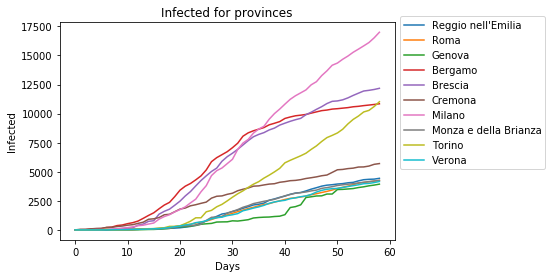

<Figure size 432x288 with 0 Axes>

In [21]:
x=len(time_line_dataset.columns[2:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)
condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])

It is possible to see a clear difference. Milano is at the top in the overall infections, but in the last graph is not present. 

@Luca: nelle prossime righe non mi è chiaro il concetto che volevi esprimere.

A couple of cities are still there, like Bergamo. For Bergamo itself we can see that is first in the line, like every news article we read, so it's probably more accurate than using all the population in an uneven situation.


@Luca: elimina la parte Miscellanous e mettila nel file Utility. Non serve qui nelle analisi. 

# Miscellanous

This code is when you downlaod the csv files on you pcs file by file.
It's no use for this notebook, avoid to compile it, it will not work.
There is also scrap code, here in case i need it again

In [ ]:

'''


'''
'''
print(len(population_time_line_dataset))
print(len(time_line_dataset))
difference =pd.Index(time_line_dataset['denominazione_provincia'].tolist()).symmetric_difference( population_time_line_dataset['denominazione_provincia'])
print(difference)
'''

'''
for filename in listdir("./dati-province\\"):
   
    temp_data= pd.read_csv("./\\"+filename)

    time_line_dataset[filename[-12:-4]]=temp_data['totale_casi']
'''

# ARIMA model

In [ ]:
###### IN THE FUTURE

model = ARIMA(???, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())